# Transfer Learning with EfficientNet-B1

In [ ]:
!pip install torchinfo

In [ ]:
from IPython.display import clear_output
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.models import efficientnet_b1, EfficientNet_B1_Weights
import matplotlib.pyplot as plt
from pathlib import Path
import os
from torchinfo import summary
import numpy as np

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Data Acquisition

In [ ]:
BASE_DIR = Path("./pizza_steak_sushi")
TRAIN_DIR = BASE_DIR / "train"
TEST_DIR = BASE_DIR / "test"

In [ ]:
if not BASE_DIR.exists():
    !wget https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/data/pizza_steak_sushi.zip -O {BASE_DIR}.zip
    !unzip pizza_steak_sushi.zip -d {BASE_DIR}
    clear_output()

# Weights

In [ ]:
weights = EfficientNet_B1_Weights.DEFAULT
weights

EfficientNet_B1_Weights.IMAGENET1K_V2

# Dataset & DataLoader

In [ ]:
weights.transforms()

ImageClassification(
    crop_size=[240]
    resize_size=[255]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [ ]:
train_transforms = weights.transforms()
test_transforms = weights.transforms()

In [ ]:
train = datasets.ImageFolder(root=str(TRAIN_DIR), transform=train_transforms)
test = datasets.ImageFolder(root=str(TEST_DIR), transform=test_transforms)

In [ ]:
train.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [ ]:
BATCH_SIZE = 32

train_dl = DataLoader(
    dataset=train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=os.cpu_count() or 1
)

test_dl = DataLoader(
    dataset=test,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=os.cpu_count() or 1
)

# Modelling

In [ ]:
def fit(model: nn.Module, dl: DataLoader, val_dl: DataLoader, optim: torch.optim.Optimizer, criterion: nn.Module, epochs=2):
    train_loss = []
    val_loss = []

    for epoch in range(epochs):
        model.train()

        batch_loss = []
        batch_acc = []

        for i, (x, y) in enumerate(dl):

            x, y = x.to(device), y.to(device)

            out = model(x)
            loss = criterion(out, y)

            batch_loss.append(loss.item())

            # accuracy calculation
            acc = (torch.softmax(out, dim=1).argmax(dim=1) == y).sum() / len(y)
            batch_acc.append(acc.item())

            optim.zero_grad()
            loss.backward()
            optim.step()

        epoch_train_loss = np.mean(np.array(batch_loss))
        epoch_train_accuracy = np.mean(np.array(batch_acc))

        train_loss.append(epoch_train_loss)

        model.eval()

        with torch.inference_mode():

            batch_loss = []
            batch_acc = []

            for i, (x, y) in enumerate(val_dl):

                x, y = x.to(device), y.to(device)

                out = model(x)
                loss = criterion(out, y)

                batch_loss.append(loss.item())

                # accuracy calculation
                acc = (torch.softmax(out, dim=1).argmax(dim=1) == y).sum() / len(y)
                batch_acc.append(acc.item())

        epoch_val_loss = np.mean(np.array(batch_loss))
        epoch_val_accuracy = np.mean(np.array(batch_acc))

        val_loss.append(epoch_val_loss)

        if epoch % 10 == 0:
            print(f"Epoch {epoch}/{epochs} | Train Loss: {epoch_train_loss} | Val Accruacy: {epoch_val_accuracy}")

    return train_loss, val_loss

In [ ]:
def plot_hist(train_loss, val_loss):
    plt.figure(figsize=(10,5))
    plt.plot(train_loss)
    plt.plot(val_loss)
    plt.legend(["Train", "Val"])
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

## Model

In [ ]:
model = efficientnet_b1(weights=weights, progress=False).to(device)
summary(
    model,
    input_size=(32, 3, 224, 224),
    col_names=["input_size", "output_size", "num_params"],
    row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape               Output Shape              Param #
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]         [32, 1000]                --
├─Sequential (features)                                      [32, 3, 224, 224]         [32, 1280, 7, 7]          --
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]         [32, 32, 112, 112]        --
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]         [32, 32, 112, 112]        864
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]        [32, 32, 112, 112]        64
│    │    └─SiLU (2)                                         [32, 32, 112, 112]        [32, 32, 112, 112]        --
│    └─Sequential (1)                                        [32, 32, 112, 112]        [32, 16, 112, 112]        --
│    │    └─MBConv (0)                                       [32, 

## Freezing and configuring

In [ ]:
for param in model.features.parameters():
    param.requires_grad = False

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(train.classes))
).to(device)

## Training

In [ ]:
LR = 1e-3
EPOCHS = 100

optimizer = torch.optim.Adam(lr=LR, params=model.parameters())
criterion = nn.CrossEntropyLoss()

In [ ]:
train_loss, val_loss = fit(model, train_dl, test_dl, optimizer, criterion, epochs=EPOCHS)

Epoch 0/100 | Train Loss: 1.1025547981262207 | Val Accruacy: 0.6306818226973215
Epoch 10/100 | Train Loss: 0.5987147502601147 | Val Accruacy: 0.9479166666666666
Epoch 20/100 | Train Loss: 0.5416571982204914 | Val Accruacy: 0.908143957455953
Epoch 30/100 | Train Loss: 0.32549124024808407 | Val Accruacy: 0.8967803120613098
Epoch 40/100 | Train Loss: 0.33211478404700756 | Val Accruacy: 0.9384469787279764
Epoch 50/100 | Train Loss: 0.27931368350982666 | Val Accruacy: 0.9583333333333334
Epoch 60/100 | Train Loss: 0.27227598801255226 | Val Accruacy: 0.9479166666666666
Epoch 70/100 | Train Loss: 0.2784087872132659 | Val Accruacy: 0.8674242496490479
Epoch 80/100 | Train Loss: 0.31521867495030165 | Val Accruacy: 0.9479166666666666
Epoch 90/100 | Train Loss: 0.1925366148352623 | Val Accruacy: 0.9176136453946432


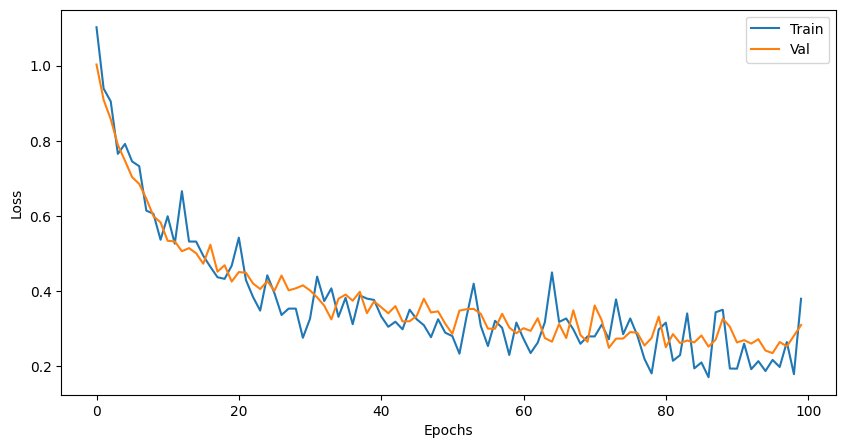

In [ ]:
plot_hist(train_loss, val_loss)